# Eindimensionaler Kalman-Filter, Teil 2 Simulationen
S. Mack, 1.3.2019

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple
gaussian = namedtuple('Gaussverteilung', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def update(prior, likelyhood):
    posterior = gaussian_multiply(likelyhood, prior)
    return posterior

Die beiden Funktionen ``update()`` und ``predict()`` aus dem letzten Notebook sind  oben aufgeführt. Dort findet sich auch der Quellcode für das Rechnen mit Gaußverteilungen. Mit diesem Code lässt sich nun ein Kalman-Filter realisieren, der einen einzelnen Zustandswert mit der bekannten Vorhersage-/Korrektur-Iteration trackt.  
Damit der Filter getestet werden kann müssen Messdaten simuliert werden. Daher wird im nächsten Abschnitt noch Code für die Simulation der Bewegung des Roboterfahrzeugs entwickelt. Die Algorithem hierfür werden durch die Klasse ``RoboSim`` implementiert.

## Klasse RoboSim für Simulation von Messdaten

Der Konstruktor ``RoboSim(x0,velocity,measurement_var,process_var)`` erhält folgende Variablen übergeben: 
* ``x0``: Startposition des Roboters. 
* ``velocity``: Die (mittlere) Positionsänderung pro Iteration, also der Erwartungswert der Geschwindigkeit.
* ``process_var``: Die Varianz des gaussförmigen Porzessrauschens, mit dem ``velocity`` beaufschlagt wird. Der Roboter bewegt sich realitätsnah *nicht* mit absolut konstanter Geschwindigkeit.
* ``measurement_var``: Die Varianz der Messunsicherheit des Positionssensors, also des Messrauschens.  
  
Die Methode `sense_position()` schlägt auf den schon durch das Prozessrauschen verrauschten wahren Positionswert zusätzlich ein Messrauschen auf.

In [2]:
import copy # needed for deepcopy() ín move_and_sense()
class RoboSim(object):

    def __init__(self, x0=0, velocity=1, process_var=0.0, measurement_var=0.0):
        ''' x0 - initial position, velocity - (+=right, -=left), process_variance - variance in process (m/s)^2, 
        measurement_variance - variance in measurement m^2 '''
        self.x = x0
        self.velocity = velocity
        self.measurement_noise = np.sqrt(measurement_var)
        self.process_noise = np.sqrt(process_var)

    def move(self, dt=1.0):
        '''compute new position of the robot assuming `dt` seconds have passed since the last update.'''
        # computes new position based on velocity + process noise added
        velocity = self.velocity + np.random.randn() * self.process_noise * dt
        self.x += velocity * dt

    def sense_position(self):
        # simulates measuring the position with measurement noise
        return self.x + np.random.randn() * self.measurement_noise

    def move_and_sense(self, dt=1.0):
        self.move(dt)
        x = copy.deepcopy(self.x)
        return x, self.sense_position() # true noisy position and measured position of robot

    def run_simulation(self, dt=1, count=1):
        ''' simulate the robot moving over a period of time and returns data: np.array[float, float],2D array, 
        column 0: true actual position of robot, column 1: measurement of robot position
        '''
        return np.array([self.move_and_sense(dt) for i in range(count)])

Im Quellcode oben ist es wichtig, den Unterschied zwischen dem Prozessrauschen und dem Messrauschen zu erkennen: 
>Das Prozessrauschen bewirkt, dass der Roboter sich nicht absolut gleichförmig bewegt. Diese schon "verrauschte" wahre Position wird von einem Sensor mit Messunsicherheit (= Messrauschen) gemessen und dadurch zusätzlich "verrauscht".

Der Rückgabewert der Funktion ``run_simulation`` ist ein Array aus Tupeln. Jedes Arrayelement entspricht einem Zeitschritt. In zugehörigen Tupel befindet sich an Position 0 der wahre Abstandswert und an Position 1 der gemessenen Abstandswert des Roboters.

Nachfolgend wird mit der Klasse ``RoboSim`` eine Fahrt des Roboterfahrzeugs simuliert und grafisch dargestellt.

### Beispiel Simulation Roboterfahrzeug

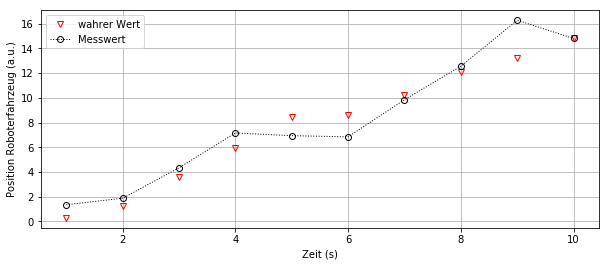

In [3]:
np.random.seed(13) # to make the simulation reproducible

process_var = 1. # variance of robot velocity, same as later in Kalman filter
sensor_var = 2. # variance distance sensor, same as later in Kalman filter

n = 10 # number of date to be simulated
x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(n)] # column 0: true position, column 1: measurend position

fig, ax = plt.subplots(figsize=(10,4))
time = range(1,n+1)
ax.plot(time, [z[0] for z in zs], color='r', mfc='None', marker = 'v', linestyle='None',label='wahrer Wert')
ax.plot(time, [z[1] for z in zs], color='k', mfc='None', marker = 'o', linestyle=':', linewidth = 1, label='Messwert')
ax.set_xlabel('Zeit (s)')
ax.set_ylabel('Position Roboterfahrzeug (a.u.)')
ax.legend()    
ax.grid()

Auf die oben simulierten Daten des Roboterfahrzeugs wird nun ein Kalman-Filter angewendet und dessen Wirkung untersucht. Dafür werden zuerst aber noch zwei Hilfsfunktionen benötigt.

## Hilfsfunktionen
### Plotfunktion für Ergebnisse Simulation mit Kalman-Filter
Nachfolgend wird eine Plotfunktion erstellt, die für die kommenden Simulationen den Verlauf der Vorhersagewerte, Messwerte und Schätzwerte (=Filteroutput) grafisch als Plot darstellt.  

In [4]:
def plot_meas_pred_est(measurements, predictions, estimates, est_vars):
    plt.figure(figsize=(10,4))
    n = len(measurements)
    time = range(1,n+1)
    meas, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None') # mfc = hollow markers
    pred, = plt.plot(time, predictions, color='k', mfc='None', marker = '+', linestyle='None')
    est, = plt.plot(time, estimates, marker = 'o', linestyle=':', linewidth = 2, markersize=3)
    est_var_min = np.asarray(estimates) - np.asarray(est_vars) # conversion to np.array because adding lists not possible
    est_var_max = np.asarray(estimates) + np.asarray(est_vars)
    plt.fill_between(time, est_var_min, est_var_max, facecolor='C0', alpha=0.2)
    
    plt.legend([meas, pred, est], ['Messwerte','Vorhersagewerte','Schätzwerte (Filter) $\pm \sigma$'], loc="upper left", 
               bbox_to_anchor=(1,1))
    plt.xlabel('Zeit (s)')
    plt.ylabel('Zustandswert (a.u.)')
    plt.grid()

Auch für den Kalmanfilter wird eine Funktion erstellt, damit die Quellcodes in diesem Notebook überschaubar bleiben. Die nachfolgende Funktion ``kal_filt_for_plot()`` filtert die übergebenen Messdaten aus ``zs`` (Position 0 der einzelnen Tupel dieser Liste) und gibt Arrays für die grafische Darstellung zurück.

### Funktion für Anwendung des Kalman-Filters auf Simulationsdaten inkl. Ergebnisplot

In [5]:
def kal_filt_for_plot(meas_data, est_start, est_start_var, process_model, sensor_var):
    posterior = gaussian(est_start, est_start_var)  # first initial guess of Robot position
    priors=[] # needed for subsequent plotting
    measurements=[]
    posteriors=[]
    post_vars=[]

    print('Wahrer Wert\tMesswert +/-Var \tVorhersagewert +/-Var\tKorrekturwert +/-Var')

    # perform Kalman filter on measurement z, process_model and sensor_var values same as for simulation.
    for z in meas_data:    
        prior = predict(posterior, process_model)
        likelihood = gaussian(z[1], sensor_var)
        posterior = update(prior, likelihood)
        print('{:6.3f}\t\t{:6.3f} +/-{:6.3f} \t{:6.3f} +/-{:6.3f}\t{:6.3f} +/-{:6.3f}'.format
              (z[0],z[1],sensor_var,prior.mean, prior.var,posterior.mean,posterior.var))
        priors.append(prior.mean)
        posteriors.append(posterior.mean)
        post_vars.append(np.sqrt(posterior.var))
        measurements.append(z[1])
    
    #plot_meas_pred_est(measurements,priors,posteriors,post_vars)
    print()
    print('final estimate:        {:10.3f}'.format(posterior.mean))
    print('actual final position: {:10.3f}'.format(robot.x))
    return measurements,priors,posteriors,post_vars

## Vorbemerkung zu den nachfolgenden Simulationen
In den nachfolgend gezeigten Simulationsbeispielen erhält der Kalman-Filter für sein physikalisches Modell die selbe Geschwindigkeit ``velocity`` und Varianz ``proces_var`` wie sie für die Simulation der Roboterbewegung verwendet wurde. Das Gleiche gilt auch für das Sensorrauschen: Das im Kalman-Filter angenommene Messwertrauschen ``sensor_var`` ist gleich zu dem simulierten Sensorrauschen ``measurement_var``.  
Diese Tatsache hat ein wenig den Beigeschmack einer Täuschung, denn bei einem realen, nicht simulierten Fahrzeug liegen diese Werte nicht vor. Letztlich kann man aber sowohl das Fahrzeug als auch den Sensor empirisch untersuchen, und erhält so Informationen zumindest zu den beiden Varianz-Parametern. Der Parameter Geschwindigkeit wird später ähnlich wie beim g-h-Filter dynamisch angepasst werden.   

## Simulation mit zehn Iterationen zur Verdeutlichung der Filterwirkung

Wahrer Wert	Messwert +/-Var 	Vorhersagewert +/-Var	Korrekturwert +/-Var
 0.288		 1.354 +/- 2.000 	 1.000 +/-401.000	 1.352 +/- 1.990
 1.243		 1.882 +/- 2.000 	 2.352 +/- 2.990	 2.070 +/- 1.198
 3.588		 4.341 +/- 2.000 	 3.070 +/- 2.198	 3.736 +/- 1.047
 5.938		 7.156 +/- 2.000 	 4.736 +/- 2.047	 5.960 +/- 1.012
 8.417		 6.939 +/- 2.000 	 6.960 +/- 2.012	 6.949 +/- 1.003
 8.628		 6.844 +/- 2.000 	 7.949 +/- 2.003	 7.396 +/- 1.001
10.191		 9.847 +/- 2.000 	 8.396 +/- 2.001	 9.122 +/- 1.000
12.105		12.553 +/- 2.000 	10.122 +/- 2.000	11.338 +/- 1.000
13.232		16.273 +/- 2.000 	12.338 +/- 2.000	14.305 +/- 1.000
14.838		14.800 +/- 2.000 	15.305 +/- 2.000	15.053 +/- 1.000

final estimate:            15.053
actual final position:     14.838


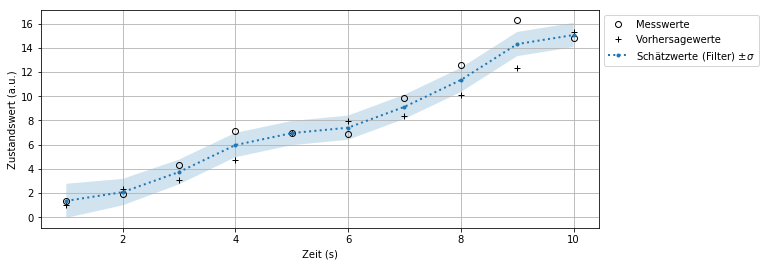

In [6]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 1. # variance of robot velocity, same as later in Kalman filter
sensor_var = 2. # variance distance sensor, same as later in Kalman filter

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perfom Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

Die wahren Roboterpositionen wurden mit der Klasse ``RoboSim`` simuliert. Die Startposition ist 0, die Geschwindigkeit 1. Mit der selben Klasse wurden auch die Messwerte simuliert: Sie streuen relativ zu den wahren Abstandswerten (die auch schon streuen) mit einer Varianz von 2.    
Der Startpostionswert des Filters beträgt 0 und hat eine Varianz von 400. Dieser Wert ist der Schätzwert zur Zeit 0, welcher nicht im Plot und auch nicht oben in der Tabelle dargestellt ist. Die große Varianz bedeutet, dass das Roboterfahrzeug am Anfang praktisch überall vermutet wird.    
Der erste Vorhersagewert ist gleich 1, denn im Prozessmodell ist eine Geschwindigkeit von 1/s angenommen und der Zeitschritt beträgt 1 s. Die Varianz dieses ersten Vorhersagewerts ist mit 401 sogar noch um 1 höher als die Varianz des Startwerts.  
Der Schätzwert für die Zeit 1 liegt deshalb sehr nahe am Messwert, da dessen Varianz mit (konstant) 2 wesentlich kleiner ist.  
Bei den nächsten Iterationen (=Zeitschritten) liegt der Schätzwert wie erwartet immer zwischen dem Vorhersagewert und dem Messwert.
  
Die Standardabweichung (*also die Wurzel der Varianz!*) des Schätzwertes ist durch das hellblaue Band markiert und engt sich rasch auf den Wert 1 ein: Die Varianz des Messwerts ist konstant 2 und die Varianz des Vorhersagewerts konvergiert gegen den Wert 2. Die Kombination dieser beiden Varianzen lässt sich als Mittelwertbildung aus zwei unabhängigen Zufallswerten mit Varianz 2 auffassen. Somit ergibt sich für den Mittelwert die halbe Varianz von 1, was gleich einer Standardabweichung von 1 ist.
> Die Varianz des des Filter-Outputs (Korrekturwert=Schätzwert) ist schon bei der zweiten Iteration deutlich kleiner als die Varianz des Messwerts. Der Kalman-Filter zeigt also große Wirkung. Zudem liegt der wahre Wert immer innerhalb des 68 % Vertrauensintervalls des Filter-Outpus.
  
Die Varianz des Vorhersagewerts nähert sich rasch dem Wert 2, da jeweils die Varianz 1 des Prozessmodells zur vorherigen Varianz des Schätzwerts hinzu kommt.

## Kalmanfilter für Simulation mit hohem Prozessrauschen

```python
process_var = 40
sensor_var = 2
```
Hier ist die Varianz des Messwerts auf lange Sicht gleich ``sensor_var``, denn die Vorhersage wird wegen ihrer ungleich höheren Unsicherheit nicht mehr ernst genommen. 

Wahrer Wert	Messwert +/-Var 	Vorhersagewert +/-Var	Korrekturwert +/-Var
-3.506		-2.440 +/- 2.000 	 1.000 +/-440.000	-2.424 +/- 1.991
-2.787		-2.148 +/- 2.000 	-1.424 +/-41.991	-2.115 +/- 1.909
 6.720		 7.473 +/- 2.000 	-1.115 +/-41.909	 7.082 +/- 1.909
16.259		17.477 +/- 2.000 	 8.082 +/-41.909	17.049 +/- 1.909
26.612		25.133 +/- 2.000 	18.049 +/-41.909	24.810 +/- 1.909
22.622		20.837 +/- 2.000 	25.810 +/-41.909	21.064 +/- 1.909
27.181		26.837 +/- 2.000 	22.064 +/-41.909	26.620 +/- 1.909
33.960		34.409 +/- 2.000 	27.620 +/-41.909	34.100 +/- 1.909
35.765		38.807 +/- 2.000 	35.100 +/-41.909	38.638 +/- 1.909
40.600		40.562 +/- 2.000 	39.638 +/-41.909	40.520 +/- 1.909

final estimate:            40.520
actual final position:     40.600


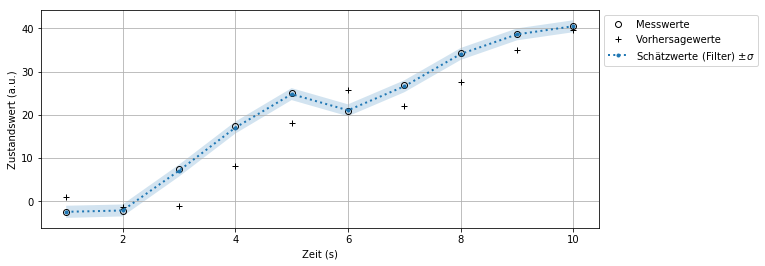

In [7]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 40.
sensor_var = 2.

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perfom Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

## Kalmanfilter für Simulation mit hohem Sensorrauschen

```python
process_var = 40
sensor_var = 2
```
Hier ist die Varianz des Korrekturwerte auf lange Sicht etwa 8. Es stellt sich ein Gleichgewicht ein: Die Vorhersagewerte liegen bei einer Varianz von ca. 10, was mit der konstanten Varianz 40 der Messwerte zu einer resultierenden Varianz von 8 kombiniert wird.

Wahrer Wert	Messwert +/-Var 	Vorhersagewert +/-Var	Korrekturwert +/-Var
-0.007		 4.760 +/-40.000 	 1.000 +/-402.000	 4.420 +/-36.380
 0.930		 3.787 +/-40.000 	 5.420 +/-38.380	 4.620 +/-19.587
 3.832		 7.199 +/-40.000 	 5.620 +/-21.587	 6.173 +/-14.020
 6.741		12.188 +/-40.000 	 7.173 +/-16.020	 8.608 +/-11.439
 9.832		 3.221 +/-40.000 	 9.608 +/-13.439	 8.001 +/-10.059
 9.717		 1.738 +/-40.000 	 9.001 +/-12.059	 7.319 +/- 9.266
11.513		 9.974 +/-40.000 	 8.319 +/-11.266	 8.682 +/- 8.790
13.805		15.812 +/-40.000 	 9.682 +/-10.790	10.985 +/- 8.498
14.985		28.585 +/-40.000 	11.985 +/-10.498	15.436 +/- 8.315
16.842		16.673 +/-40.000 	16.436 +/-10.315	16.484 +/- 8.201

final estimate:            16.484
actual final position:     16.842


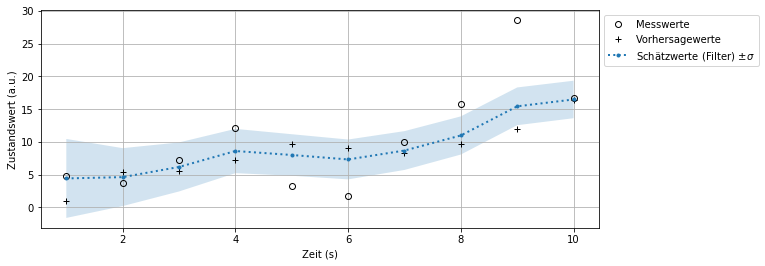

In [8]:
np.random.seed(13) # to make the simulation reproducible
est_start = 0
est_start_var = 400

process_var = 2.
sensor_var = 40.

x_start = 0
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity, process_var) # for simulation same parameters as later in Kalman filter
  
# simulate robot and get measurements
robot = RoboSim(x0=x_start,velocity=process_model.mean,measurement_var=sensor_var,process_var=process_model.var)

# create list of measurements
zs = [robot.move_and_sense() for _ in range(10)] # column 0: true position, column 1: measurend position
# perfom Kalman tracking and plot results, * needed to unpack arguments out of the list
plot_meas_pred_est(*kal_filt_for_plot(zs,est_start,est_start_var,process_model,sensor_var))

## Allgemeine Notation und Bezeichnungen für den Kalman-Filter in der Literatur

Es gibt viele, auch gute Lehrbücher zum Kalman-Filter. Sie haben aber fast alle gemeinsam, dass sie zuerst die Theorie behandeln und erst dann den tapferen Leser mit praktischen Beispielen verwöhnen.  
In diesen Notebooks wird bewusst auf die "reine Theorie" verzichtet. Der Kalman-Filter wurde hier Schritt für Schritt intuitiv mit vielen Beipsielen und Simulationen entwickelt.  

Will man sich näher mit dem Kalman-Filter befassen und auch die Theorie dahinter verstehen, dann ist es wichtig, die Notationen und Bezeichnungen aus der Literatur den Bezeichnungen in diesen Notebooks zuordnen zu können. Dies ist der Sinn und Zweck dieses Abschnitts.  

Im Korrekturschritt sind sowohl der Vorhersagewert als auch der Messwert Gaußverteilungen, die jeweils mit einem Erwartungswert $\bar\mu$ bzw. $\mu_z$ und einer Varianz $\sigma^2$ bzw. ${\sigma_z}^2$ definiert werden.  

Der Korrekturwert (auch Posterior oder Schätzwert) wird über folgende Formel berechnet:

$$
\hat\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

Dies kann umgeformt werden zu:

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

Letztlich sieht man oben wieder wie beim g-h-Filter einen gewichteten Mittelwert aus Vorhersagewert und Messwert. Aus den beiden Gewichtungsfaktoren in den Klammern wird nun wie beim beim g-h-Filter ein Gain berechnet, der dem Parameter $g$ des g-h-Filters entspricht: 

Mit 
$$K=\frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$ 
ergibt sich:

$$\begin{aligned}
\hat\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

> $K$ wird in der Literatur als *Kalman gain* bezeichnet. Er ist das Verhältnis der Gewichtung des Vorhersagewerts im Vergleich zum Messwert.

Der dem g-h-Filter entsprechende Parameter $h$ wird hier übrigens noch nicht implementiert.

### Neuimplementierung der Kalman-Filter-Iterationsschritte "update" und "predict"
Nachfolgend sind neue Implementierungen der Funktionen ``update()`` and ``predict()`` dargestellt. Vom Algorithmus her sind sie identisch zu denen am Beginn dieses Notebooks. Hier werden lediglich die Bezeichnungen denen der in der Literatur angepasst.

In [9]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance, product of two gaussians
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q # prior, sum of two gaussions
    return gaussian(x, P)

Zum besseren Verständnis ist nachfolgend nochmals eine Iteration aus Vorhersage und Korrektur grafisch dargestellt.  
>Der Kalman Gain $K$ bestimmt, wo der neue Schätzwert entlang des Residuums zu liegen kommt.  

<img src="grafikKalman_VorhersKorr.png" width="800">  

In der vorherigen Notation war $z = \mu_z$ und $x_t = \bar \mu$.

Die im Quellcode verwendeten Bezeichnungen ``z``, ``P``, ``Q`` und ``R`` findet man sehr oft in Literatur zum Kalman-Filter. Sie sind eine Standardnotation für den Kalman-Filter.
+ $z$ steht meistens für den Messwert.
+ $R$ steht für Varianz des Messwerts.
+ $Q$ steht für Varianz des Prozesses.
+ $P$ steht für die Varianz des Zustands, also des Priors (Vorhersagewert) oder des Posteriors (Korrekturwert)

### Korrespondenz der Bezeichnungen zum Buch "Kalman-Filter" von R. Marchthaler  und S. Dingler
Dieses aktuelle Buch bietet die Möglichkeit, sich tiefer in den Thematik des Kalman-Filters einzuarbeiten. Hier sind auch die nötigen theoretischen Grundlagen erklärt.  
Damit der Umstieg von dieser Notebookreihe auf das Fachbuch gelingt, sind in der Tabelle die Begrifflichkeiten verglichen.


| Parameter in diesem Notebook | entsprechender Parameter Marchthaler |            Bemerkung            |
| :--------------------------- | :----------------------------------: | -------------------------------:|
| Prior, Vorhersagewert $\bar x$ | prädizierter Zustandsvektor $\hat {\underline x}(k)$ | Ausgang predict()<br/>selbe Messgröße wie z|
| Varianz Prior P | prädizierte Kovarianz des Schätzfehlers $\hat{\underline P}(k)$ | Ausgang predict() |
| Posterior, Korrekturwert $\hat x$ | Korrigierter Zustandsvektor $\tilde {\underline x}(k)$ | Ausgang update() |
| Varianz zPosterior P | korrigierte Kovarianz des Schätzfehlers $\tilde{\underline P}(k)$ | Ausgang update() |
| Messwert z | Ausgangsvektor ${\underline y}(k)$| hier Abstand |
| Varianz Messwert R | Varianz Messrauschen ${\underline R}(k)$ | hier const. |
| - | prädizierter Messwert $\hat {\underline y}(k)$| = $\underline C \cdot \hat {\underline x}(k)$ meist = $\hat {\underline x}(k)$ |
| Bewegung dx | steckt in Systemmatrix ${\underline {A_d}}(k)$| hier: v = const., im Buch: $f(v,a) \neq $const.|
| Varianz Prozess Q | Systemrauschen ${\underline Q}(k)$ | Zunahme Varianz Prior x durch Prädiktion |
| Kalman Gain K | Kalmanverstärkung ${\underline K}(k)$ | Input $\hat {\underline P}(k) , {\underline R}(k)$ |
| Residuum y | $\Delta \underline y(k)$ | engl. "residual" |

In der Einleitung dieses Buchs ist am Beispiel der Mondlandefähre der Kalmanfilter erklärt. Hier handelt es sich aber im Gegensatz zu diesem Notebook um einen zweidimensionalen Kalmanfilter, bei dem der Zustandsvektor nicht aus dem einen Element einer Ortskoordinate sondern aus der Ortskoordinate h, der Geschwindigkeit v und der Beschleunigung a besteht. Messwerte existieren nur für h und a. v ist durch die Matrix C immer gleich Null. Das bedeutet vermutlich, dass v zwar eine Zustandsgröße aber kein Messwert ist.  
Die Rolle des Eingangsvektors $\underline u(k)$ ist im Buch ebenfalls unklar. Vermutlich hat dieser Vektor rein gar nichts mit dem Filteralgorithmus selbst zu tun. Dem Autor dieses Notebooks fällt es also übrigens auch schwer, die reine Theorie eines Kalmanfilters aus dem Buch von Marchthaler et al. zu verstehen...

### Die Gleichungen und Implementierungen für einen Kalman-Filter

Zu Übersicht sind hier nochmals die verschiedenen Gleichungen aufgeführt, die in diesem und den voran gegangenen Notebook im Zusammenhang mit dem Kalman-Filter aufgetaucht sind:


<u>Vorhersage</u>

$\begin{array}{|l|l|l|}
\hline
\text{Gleichung} & \text{Implementierung} & \text{Kalman-Form}\\
\hline
 \bar x = \hat x + f_x & \bar\mu = \hat\mu + \mu_{f_x} & \bar x = \hat x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Korrektur</u>

$\begin{array}{|l|l|l|}
\hline
\text{Gleichung} & \text{Implementierung}& \text{Kalman-Form}\\
\hline
 \hat x = \| \mathcal L \circ  \bar x\| & y = \mu_z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \hat\mu = \bar \mu + Ky & \hat x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

### Der generische Algorithmus eines Kalman-Filters

>Ein Kalman-Filter erstellt eine Vorhersage, macht eine Messung und berechnet daraus einen Korrekturwert (auch Schätzwert genannt) der zwischen dem Vorhersagewert und dem Messwert liegt.  
Egal welches Lehrbuch über Kalman-Filter man aufschlägt, zugrunde liegt immer dieser Algorithmus. Er wird nur unterschiedlich mathematisch implementiert. So unterscheiden sich die verschiedenen Lehrbücher und Implementierungen im Wesentlichen in der verwendeteten Mathematik *jedoch nicht im Algorithmus*.

Dieser generische Kalman-Filter-Algorithmus lässt sich in neun Schritten beschreiben: 
  
**Initialisieung**

    1. Den Status des Filters initialisieren mit dem Prozessmodell (Erwartungswert, Unsicherheit).
    2. Einen Startwert der Zustandsgröße (Wert, Unsicherheit) willkürlich festlegen.
    
**Vorhersage**

    1. Den Zustandswert (Prior) für den nächsten Zeitschrit mit Hilfe es Prozessmodells vorhersagen.
    2. Die Unsicherheit des Prozessmodells in die Unsicherheit des Vorhersagewerts einfließen lassen.
    
**Korrektur**

    1. Eine Messung durchführen und wenn möglich deren Unsicherheit bestimmen, falls diese nicht als konstant angenommen
    wird.
    2. Das Resuiduum von Messwert minus Vorhersagewert berechnen.
    3. Den Gewichtungsfaktor (Kalman Gain) über den Vergleich der Unsicherheit von Messwert und Vorhersagewert berechnen.
    4. Mit dem Gewichtungsfaktor den Korrekturwert zwischen Messwert und Vorhersagewert verorten.
    5. Die Unsicherheit des Korrekturwerts über die Unsicherheiten von Mess- und Vorhersagewert berechnen.
    
**Bemerkung:** Oben wurde bewusst der Begriff "Unsicherheit" statt "Varianz" verwendet, obwohl damit Letzters gemeint ist. 

### Neuimplementierung der Funktion kal_filt_for_plot()
Nachfolgend wird die Funktion ``kal_filt_for_plot()`` nochmals neu mit den aktualisierten Funktionen ``update()`` und ``predict()`` implementiert. Dadurch wird der Code übersichtlicher, kann besser mit Codebeispielen aus der Literatur verglichen werden und später für Übungen wieder verwendet werden.  
Im Array ``zs`` befinden sich nach wie vor die wahren Werte (Spalte 0) und und die Messwerte (Spalte 1).

In [10]:
def kal_filt(z_vals, z_var, x_start, process_model, do_print=False):
    x = x_start  # first initial guess of Robot position
    priors=[] # needed for subsequent plotting
    measurements=[]
    x_vals=[]
    x_vars=[]

    if do_print: print('Wahrer Wert\tMesswert +/-Var \tVorhersagewert +/-Var\tKorrekturwert +/-Var')

    # perform Kalman filter on measurements zs
    for z in z_vals:    
        prior = predict(x, process_model)
        x = update(prior, gaussian(z[1], z_var))
        if do_print: print('{:6.3f}\t\t{:6.3f} +/-{:6.3f} \t{:6.3f} +/-{:6.3f}\t{:6.3f} +/-{:6.3f}'.format
              (z[0],z[1],sensor_var,prior.mean, prior.var,x.mean,x.var))
        priors.append(prior.mean)
        x_vals.append(x.mean)
        x_vars.append(np.sqrt(x.var))
        measurements.append(z[1])
    print('Letzter Schätzwert:  {:10.3f}'.format(x.mean))
    return measurements,priors,x_vals,x_vars

## Einführung Design eines Kalman-Filters

Die Auslegung eines Kalmanfilters hängt immer vom Sensorverhalten und vom zugrunde liegenden pyhsikalischen Modell (Prozessmodell) ab.  
Angenommen, nun soll nicht mehr ein Roboterfahrzeug sondern ein Thermometer getrackt werden:  
Die Zustandsgröße ist die Temperatur, welche mit einem integrierten Temperatursensor gemessen wird. Der Sensor gibt die Temperatur in °C als Spannungswert aus. Der Sensorhersteller spezifiziert das Rauschen dieses Sensors mit 0,13 V (Standardabweichung).

Somit werden für den Temperatursensor mit folgender Funktion Messwerte simuliert:

In [11]:
def volt(voltage, std): # simulation of thermometer readings
    return voltage, voltage + (np.random.randn() * std) # true value, noisy value

Die Varianz der Messwerte ist über das Datenblatt bekannt. Für das Prozessmodell wird angenommen, dass die Temperatur weitgehend konstant bleibt, da sich das Thermometer beispielsweise in einem klimatisierten Raum befindet.  
Diese angenommene Temperaturänderung ist der Erwartungswert des Prozessmodells. Würde man nun auch noch eine Varianz von 0 für das Prozessmodell annehmen, dann würde der Filter so träge, dass er selbst kleinsten Temperaturschwankungen besispielsweise durch kurzes Lüften nicht mehr folgt.  
In diesem Fall macht es also Sinn, einen Wert für ``process_var`` größer Null zu wählen.

Letzter Schätzwert:      16.305


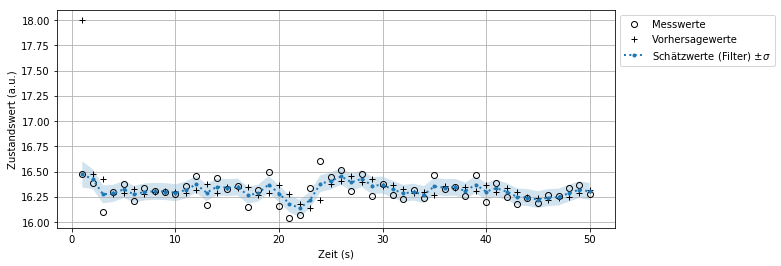

In [12]:
np.random.seed(10)

temp_change = 0
voltage_std = 0.13 # try different values, nominal value 0.13
process_var = 0.005 # try different values, nominal value 0.005
true_voltage = 16.3 # true value of constant temperature

x_start = gaussian(18., 1000.) # initial state
process_model = gaussian(0., process_var)
z_vars = voltage_std**2

N = 50
z_vals = [volt(true_voltage, voltage_std) for i in range(N)]
plot_meas_pred_est(*kal_filt(z_vals, z_vars, x_start, process_model))

Aufgrund der Raumklimatisierung ist der Parameter ``temp_change`` am einfachsten festzulegen. Wäre das Thermometer im Außenbereich, dann ginge das nicht so einfach.  
Der Parameter ``process_var`` ist schon schwerer festzulegen:  
**Frage:** Welche Schwankungen sind z.B. durch das Lüften zu erwarten? Wie groß darf man diesen Parameter wählen, damit der Filter nicht dem Sensorrauschen folgt?  
**Antwort:** Entscheidend ist für den Filter die Information über das Sensorrauschen ``voltage_std``: Nur wenn dieser Wert stimmt, dann werden die Messwerte auch mit einer angemessenen Signifikanz in den Filter mit einbezogen. Ist der Wert zu hoch, dann wird dem Sensor zu wenig vertraut. Ist der Wert zu klein, dann wird das Sensorrauschen fälschlicherweise als echte Temperaturschwankung interpretiert.

## Fixed Gain Kalman-Filter

Bei den Simulationen zum Roboterfahzeug, wo für jede Iteration die verschiedenen Werte des Filters in Textform ausgegeben werden, war auffällig, dass die Varianzen der Messwerte und der Vorhersagewerte jeweils zu einem bestimmten Wert hin konvergierten. Dies liegt daran, dass konstante Varianzen für den Sensor und für das Prozessmodell verwendet wurden.  

Sind diese Konvergenzwerte bekannt, dann kann man auch einen Kalman-Filter mit konstantem fest vorgegebenem Gain implementieren. Dann muss man aber auch den Filter mit einem guten Startwert initialisieren.

In diesem Fall würde sich der Quellcode wie folgt vereinfachen:

```python
def update(x, z):
    K = const  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + dx
```

Bei preissensiblen Anwendungen kann man so Kosten für die Hardware einsparen. 

## Schlussbemerkung

**Das Ziel dieser Reihe von Jupyter-Notbooks war eine leicht verständliche Einführung in den Kalman-Filter ohne allzu viel Theorie in Form von Wahrscheinlichkeitsrechnung.**  
Der Kalman-Filter gehört zu den Bayes-Filtern, die Bayes-Filter verwenden den Vorhersage-/Korrektur-Algorithmus des g-h-Filters. Aus diesem Grund wurde nicht der direkte Weg zum Kalmanfilter sondern der Umweg über den g-h-Filter und anschließend über den Bayes-Filter eingeschlagen.    
Der Kalman-Filter basiert auf der Gaußschen Wahrscheinlichkeitsrechnung, weshalb kurz vor Schluss auch hierzu ein Notebook durchgearbeitet werden musste.  

Die Begrifflichkeiten in fast allen Lehrbüchern zum Kalman-Filter sind zwar mathematisch korrekt und in sich konsistent, jedoch aber nicht immer hilfreich für das Verstehen. Matrizenrechnung ist nicht jedermanns Steckenpferd!  
Daher wurde hier der Kalman-Filter mit ganz einfacher Mathematik entwickelt. Erst in diesem Notebook wurde dann die Brücke zur üblichen Notation in den Lehrbüchern geschlagen.  

Python wie auch MATLAB eignen sich ideal, sich dem Thema Kalman-Filter experimentell quasi spielerisch zu näheren. Dies in Kombination mit einem guten weiterführenden Lehrbuch ist vermutlich das Erfolgsrezept, später einmal diesen Filter in einem autnom fahrenenden Auto erfolgreich einzusetzen.